In [ ]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


We are performing a Supervised learning which involves modeling the relationship between recorded values of  features and their corresponding labels ; Once this model is determined, it can be used to do inference on new recorded values of features to assciate them with one of the labels. It is further a classification task where the labels are discrete.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
default_dir = '/content/drive/MyDrive/icr-identify-age-related-conditions'
# default_dir = 'icr-identify-age-related-conditions'

train.csv - The training set.

*   Id Unique identifier for each observation.
*   AB-GL 56 anonymized health characteristics. All are numeric except  for EJ, which is categorical.
*   Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions
*   0 indicates they have not.



# Reading the training data
Rows = 617
Features = 58

In [ ]:
train_df = pd.read_csv(os.path.join(default_dir,'train.csv'))

print(f'Training Data Shape: {train_df.shape}')

train_df.head()

Training Data Shape: (617, 58)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


# Investigating missing values per column and imputing them accordingly.

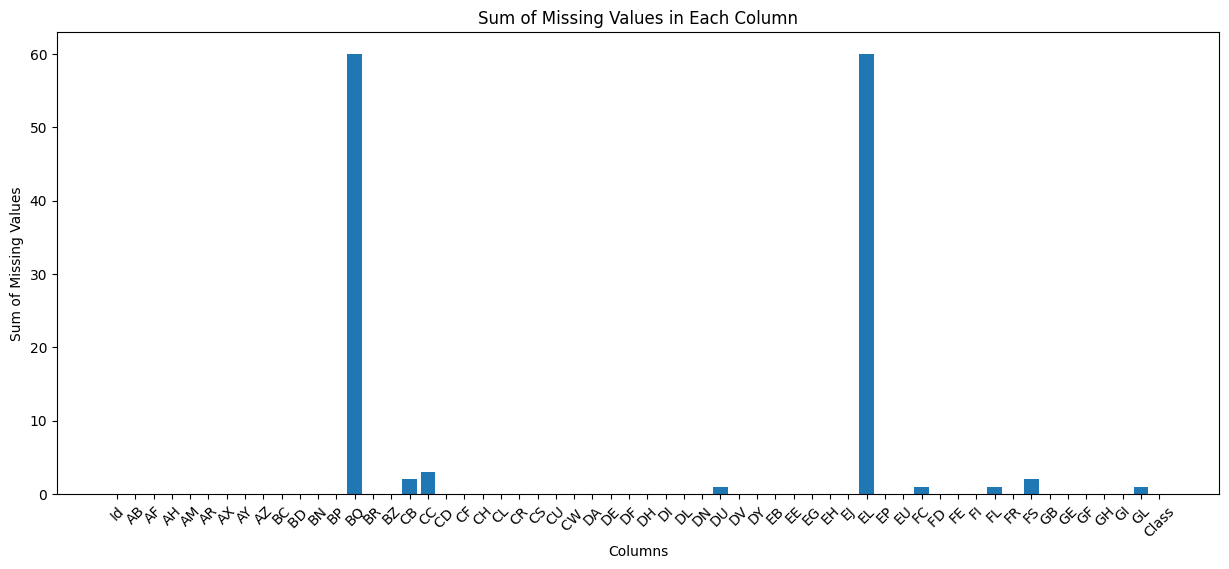

In [ ]:
missing_values_sum = train_df.isnull().sum()

# Plotting the sum of missing values
plt.figure(figsize=(15, 6))
plt.bar(missing_values_sum.index, missing_values_sum.values)
plt.xlabel('Columns')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values in Each Column')
plt.xticks(rotation=45)
plt.show()

#Utility function to calculate statistical properties of columns grouped by class and irrespective of the class respectively.

In [ ]:
def calc_stats(df,column):
    # Calculate the median value of column
    median = df[column].median()
    print("median \t ",median)

    # Calculate the median value of  column grouped by 'Class'
    median_by_class = df.groupby('Class')[column].median()
    print("median_by_class \t ",median_by_class)

    # Calculate the mean value of  column
    mean = df[column].mean()
    print("mean \t",mean)

    # Calculate the mean value of column grouped by 'Class'
    mean_by_class = df.groupby('Class')[column].mean()
    print("mean_by_class \t",mean_by_class)

    return median,median_by_class,mean,mean_by_class


# Column BQ

In [ ]:
_= calc_stats(train_df,'BQ')

median 	  61.642115
median_by_class 	  Class
0     53.775015
1    129.808452
Name: BQ, dtype: float64
mean 	 98.32873688509873
mean_by_class 	 Class
0     85.032271
1    153.607564
Name: BQ, dtype: float64


In [ ]:
# Find rows with missing data in 'BQ'
missing_rows = train_df[train_df['BQ'].isnull()]

missing_rows["Class"].value_counts()

0    60
Name: Class, dtype: int64

In [ ]:
#It makes sense to choose the BQ_median_by_class 0 to use as imputed value.
train_df = train_df.fillna(value={'BQ': 53.775015})

# Lets investigate the other missing data

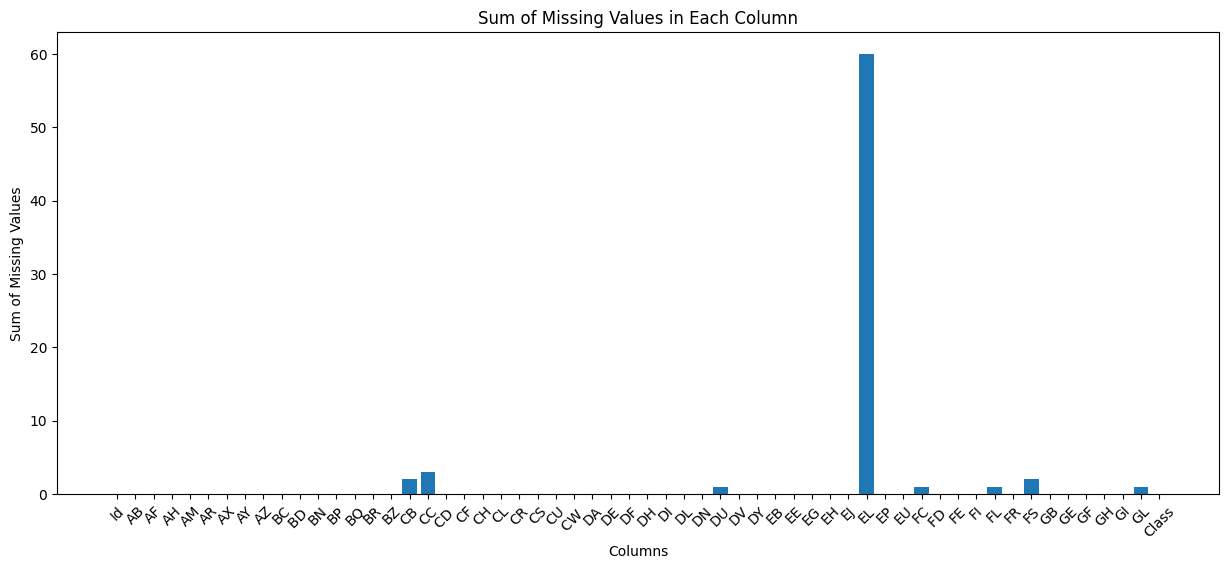

In [ ]:
missing_values_sum = train_df.isnull().sum()

# Plotting the sum of missing values
plt.figure(figsize=(15, 6))
plt.bar(missing_values_sum.index, missing_values_sum.values)
plt.xlabel('Columns')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values in Each Column')
plt.xticks(rotation=45)
plt.show()

# Column EL

In [ ]:
_= calc_stats(train_df,'EL')

median 	  71.949306
median_by_class 	  Class
0     68.992209
1    109.125159
Name: EL, dtype: float64
mean 	 69.58259579622981
mean_by_class 	 Class
0    68.343334
1    75.110674
Name: EL, dtype: float64


In [ ]:
# Find rows with missing data in 'EL'
missing_rows = train_df[train_df['EL'].isnull()]

missing_rows["Class"].value_counts()

0    54
1     6
Name: Class, dtype: int64

In [ ]:
# Define the median value of EL grouped by class to fill for each missing values based on their class.
fill_values = {
    0 : 68.992209,
    1 : 109.125159
}

In [ ]:
# Fill missing values in 'EL' column based on 'Class'
train_df['EL'] = train_df.apply(lambda row: fill_values[row['Class']] if pd.isnull(row['EL']) else row['EL'], axis=1)


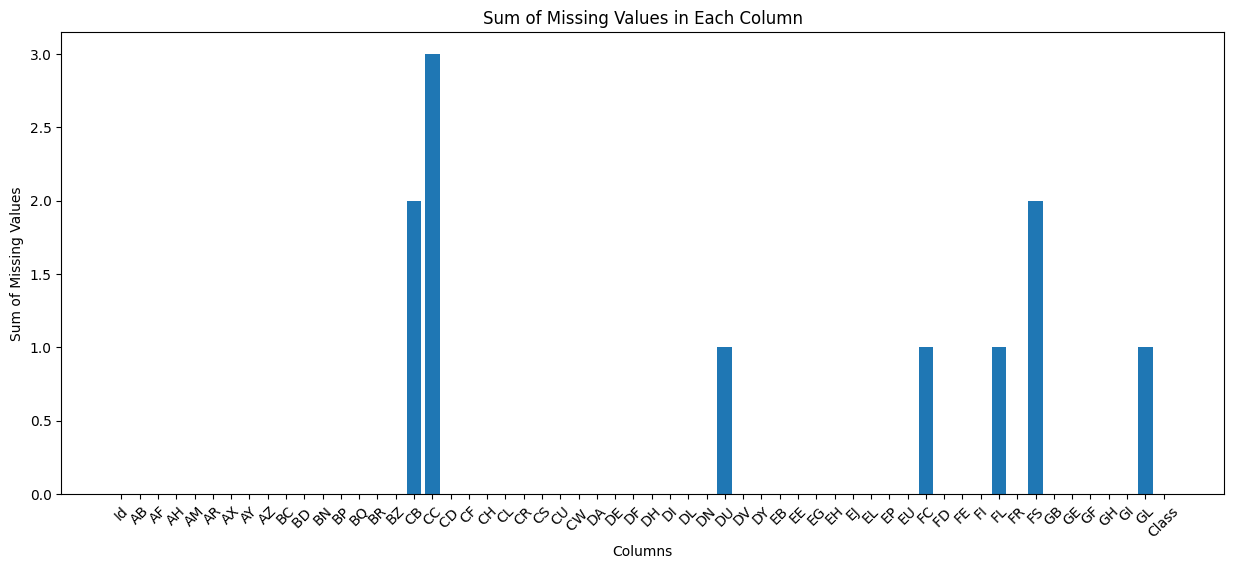

In [ ]:
missing_values_sum = train_df.isnull().sum()
# Plotting the sum of missing values
plt.figure(figsize=(15, 6))
plt.bar(missing_values_sum.index, missing_values_sum.values)
plt.xlabel('Columns')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values in Each Column')
plt.xticks(rotation=45)
plt.show()

# Column CB

In [ ]:
_= calc_stats(train_df,'CB')

median 	  42.55433
median_by_class 	  Class
0    42.802487
1    40.922928
Name: CB, dtype: float64
mean 	 77.10415084878048
mean_by_class 	 Class
0    78.188045
1    72.015868
Name: CB, dtype: float64


In [ ]:
# Find rows with missing data in 'CB'
missing_rows = train_df[train_df['CB'].isnull()]

missing_rows["Class"].value_counts()

0    2
Name: Class, dtype: int64

In [ ]:
#It makes sense to choose the CB_median_by_class 0 to use as imputed value.
train_df = train_df.fillna(value={'CB': 42.802487})

# Column CC

In [ ]:
_= calc_stats(train_df,'CC')

median 	  0.6587154900000001
median_by_class 	  Class
0    0.670100
1    0.579919
Name: CC, dtype: float64
mean 	 0.6888014997068403
mean_by_class 	 Class
0    0.695433
1    0.657380
Name: CC, dtype: float64


In [ ]:
# Find rows with missing data in 'CC'
missing_rows = train_df[train_df['CC'].isnull()]

missing_rows["Class"].value_counts()

0    2
1    1
Name: Class, dtype: int64

In [ ]:
# Define the value to fill for each class
fill_values = {
    0 : 0.670100,
    1 : 0.579919
}

In [ ]:
# Fill missing values in 'CC' column based on 'Class'
train_df['CC'] = train_df.apply(lambda row: fill_values[row['Class']] if pd.isnull(row['CC']) else row['CC'], axis=1)


# Column DU

In [ ]:
_= calc_stats(train_df,'DU')

median 	  0.25174050000000003
median_by_class 	  Class
0    0.162079
1    2.669139
Name: DU, dtype: float64
mean 	 1.8029004321428572
mean_by_class 	 Class
0    0.716517
1    6.912927
Name: DU, dtype: float64


In [ ]:
# Find rows with missing data in 'DU'
missing_rows = train_df[train_df['DU'].isnull()]

missing_rows["Class"].value_counts()

0    1
Name: Class, dtype: int64

In [ ]:
#It makes sense to choose the DU_median_by_class 0 to use as imputed value.
train_df = train_df.fillna(value={'DU': 0.162079})

# FC

In [ ]:
_= calc_stats(train_df,'FC')

median 	  36.394008
median_by_class 	  Class
0    36.579648
1    34.734672
Name: FC, dtype: float64
mean 	 71.34152618181818
mean_by_class 	 Class
0    69.013989
1    82.413644
Name: FC, dtype: float64


In [ ]:
# Find rows with missing data in 'FC'
missing_rows = train_df[train_df['FC'].isnull()]

missing_rows["Class"].value_counts()

1    1
Name: Class, dtype: int64

In [ ]:
#It makes sense to choose the FC_median_by_class 1 to use as imputed value.
train_df = train_df.fillna(value={'FC': 34.734672})

# FL

In [ ]:
_= calc_stats(train_df,'FL')

median 	  3.0281409595
median_by_class 	  Class
0    2.463620
1    7.248373
Name: FL, dtype: float64
mean 	 5.433198835689935
mean_by_class 	 Class
0     4.139887
1    11.516557
Name: FL, dtype: float64


In [ ]:
# Find rows with missing data in 'FL'
missing_rows = train_df[train_df['FL'].isnull()]

missing_rows["Class"].value_counts()

0    1
Name: Class, dtype: int64

In [ ]:
#It makes sense to choose the FL_median_by_class 0 to use as imputed value.
train_df = train_df.fillna(value={'FL': 2.463620})

# FS

In [ ]:
_= calc_stats(train_df,'FS')

median 	  0.250601
median_by_class 	  Class
0    0.250601
1    0.257374
Name: FS, dtype: float64
mean 	 0.42150086016260163
mean_by_class 	 Class
0    0.420819
1    0.424737
Name: FS, dtype: float64


In [ ]:
# Find rows with missing data in 'FS'
missing_rows = train_df[train_df['FS'].isnull()]

missing_rows["Class"].value_counts()

1    1
0    1
Name: Class, dtype: int64

In [ ]:
# Define the value to fill for each class
fill_values = {
    0 : 0.250601,
    1 : 0.257374
}

In [ ]:
train_df['FS'] = train_df.apply(lambda row: fill_values[row['Class']] if pd.isnull(row['FS']) else row['FS'], axis=1)



# GL

In [ ]:
_= calc_stats(train_df,'GL')

median 	  0.33782749300000003
median_by_class 	  Class
0    0.435421
1    0.107237
Name: GL, dtype: float64
mean 	 8.530960818952922
mean_by_class 	 Class
0    9.098095
1    5.863328
Name: GL, dtype: float64


In [ ]:
# Find rows with missing data in 'GL'
missing_rows = train_df[train_df['GL'].isnull()]

missing_rows["Class"].value_counts()

0    1
Name: Class, dtype: int64

In [ ]:
train_df = train_df.fillna(value={'GL': 0.435421})

With that, the missing values are imputed accordingly.

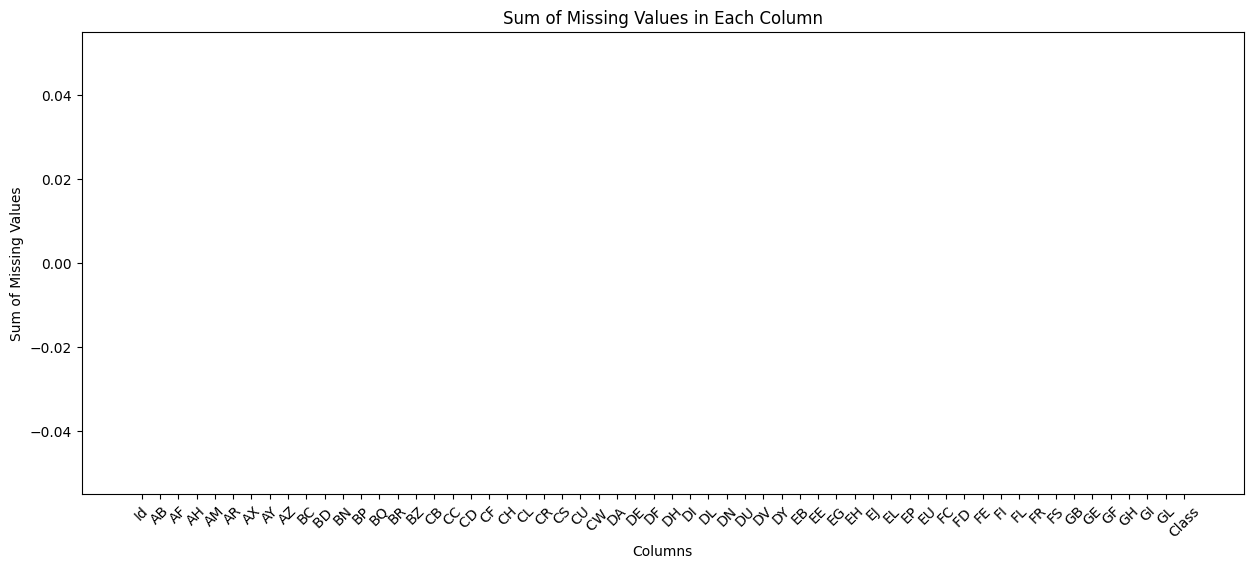

In [ ]:
missing_values_sum = train_df.isnull().sum()
# Plotting the sum of missing values
plt.figure(figsize=(15, 6))
plt.bar(missing_values_sum.index, missing_values_sum.values)
plt.xlabel('Columns')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values in Each Column')
plt.xticks(rotation=45)
plt.show()

Dropping the "Id" column

In [ ]:
train_df.drop("Id",axis=1,inplace=True)

In [ ]:
train_df.shape

(617, 57)

"EJ" is categorical. Generating dummies and concatenating the same to the original dataframe and removing the categorical feature.

In [ ]:
train_df['EJ'].unique()

array(['B', 'A'], dtype=object)

In [ ]:
# Convert int values to categorical features
converted_df = pd.get_dummies(train_df['EJ'], prefix='feature')

# Concatenate the converted features with the original DataFrame
train_df = pd.concat([train_df, converted_df], axis=1)

In [ ]:
train_df.drop("EJ",axis=1,inplace=True)

Rows= 617
Features = 57

In [ ]:
train_df.shape

(617, 58)

In [ ]:
df=train_df

# Lets check the class distribution . The data collected is highly imbalanced , roughly 1:5

In [ ]:
class_distribution = df['Class'].value_counts()
class_distribution

0    509
1    108
Name: Class, dtype: int64

# To avoid Redundancy , Overfitting and Instability , lets check the features highly correlated to each other , and get them removed for better interpretation.

In [ ]:
#Separate Class feature temporarily
target_temp = df['Class']
feature_matrix = df.drop(columns = ['Class'])

In [ ]:
# Threshold for removing correlated variables (without Class)
threshold = 0.8

# Calculate correlation matrix
corr_matrix = feature_matrix.corr(numeric_only=True)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 5 features to remove.


In [ ]:
#Remove correlated features
feature_matrix = feature_matrix[[col for col in feature_matrix.columns if col not in collinear_features]]

# Scaling the features to bring all the features in the range 0-1 . Algorithms converge faster when features are scaled. When the features have vastly different scales, the optimization process can become skewed and take longer to converge to the optimal solution.

In [ ]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(feature_matrix)
train = scaler.transform(feature_matrix)

# Feature names
features = list(feature_matrix.columns)
feature_matrix = pd.DataFrame(data=train, columns=features)

#and the response feature (Class) is reattached.
feature_matrix['Class'] = target_temp



In [ ]:
feature_matrix.shape

(617, 53)

In [ ]:
feature_matrix.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,feature_B,Class
0,0.021082,0.102347,0.00000,0.030632,0.0,0.000000,0.000000,0.180337,0.002958,0.047364,...,0.000998,0.000866,0.054959,0.000000,0.013846,0.176983,0.362261,0.005425,1.0,1
1,0.010541,0.027589,0.00000,0.053864,0.0,0.078048,0.000000,0.284500,0.000000,0.074042,...,0.000000,0.016014,0.039418,0.000000,0.194527,0.274495,0.164135,1.000000,0.0,0
2,0.063949,0.085715,0.00000,0.046519,0.0,0.160575,0.000000,0.265013,0.000000,0.067011,...,0.000385,0.036139,0.250424,0.011229,0.095035,0.258994,0.180218,0.008910,1.0,0
3,0.028110,0.127285,0.01918,0.117854,0.0,0.079462,0.000000,0.215235,0.000000,0.048203,...,0.000000,0.006925,0.109565,0.006882,0.014475,0.425143,0.470820,0.007039,1.0,0
4,0.049192,0.124246,0.00000,0.017417,0.0,0.086300,0.002841,0.000000,0.069008,0.078555,...,0.038597,0.001731,0.093459,0.051588,0.059198,0.500829,0.185841,0.004345,1.0,1


In [ ]:
feature_matrix.to_csv("Dataset1_scaled_Raw Features_Imbalanced.csv")

Splitting the Dataset into training and test dataset.

In [ ]:
#splitting application_train_newdf into train and test
train,test = train_test_split(feature_matrix,test_size=.20,random_state = 123)

#separating dependent and independent variables (no under/over sampling)
train_X = train[[i for i in train.columns if i not in ['Class']]]
train_Y = train[["Class"]].astype(int)

test_X  = test[[i for i in test.columns if i not in ['Class']]]
test_Y  = test[["Class"]].astype(int)

In [ ]:
train.shape

(493, 53)

In [ ]:
count = train['Class'].value_counts()
count

0    406
1     87
Name: Class, dtype: int64

In [ ]:
test.shape

(124, 53)

In [ ]:
count = test['Class'].value_counts()
count

0    103
1     21
Name: Class, dtype: int64

# Class imbalance in training dataset. We have to loop through the dataset and try different random subsets for a better score.

In [ ]:
# Down-sample Majority Class

count = train['Class'].value_counts()
num_majority = count[0]
num_minority = count[1]

print("num_majority ",num_majority)
print("num_minority ",num_minority)

#separating majority and minority classes
df_majority = train[train["Class"] == 0]
df_minority = train[train["Class"] == 1]

df_majority_undersampled = resample(df_majority, replace=False,
                                   n_samples=num_minority,
                                   random_state=123)

df_undersampled = pd.concat([df_minority,df_majority_undersampled],axis=0)
df_undersampled["Class"] = df_undersampled["Class"].astype(int)

#splitting dependent and independent variables

df_undersampled_X = df_undersampled[[i for i in df_undersampled.columns if i not in ['Class']]]
df_undersampled_Y = df_undersampled[["Class"]].astype(int)



num_majority  406
num_minority  87


In [ ]:
# Post Downsampling, 87+87 = 174
df_undersampled_X.shape

(174, 52)

In [ ]:
df_undersampled_Y.shape

(174, 1)

# Saving the balanced training data

In [ ]:
# Create a new DataFrame with the added column
Train_data_raw_features = df_undersampled_X.copy()

# Attaching 'Class'
Train_data_raw_features['Class'] = df_undersampled[["Class"]].astype(int)


# Save the new DataFrame to a CSV file
Train_data_raw_features.to_csv('Balanced_Train_data_raw_features.csv', index=False)

# Print the new DataFrame
Train_data_raw_features.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,feature_B,Class
436,0.084329,0.159848,0.015801,0.058559,0.000000,0.227069,0.000000,0.243578,0.003871,0.072793,...,0.000823,0.000000,0.279457,0.084943,0.000000,0.259513,0.539074,0.008395,1.0,1
36,0.031623,0.127299,0.000000,0.007896,0.000000,0.081113,0.000000,0.000000,0.000000,0.042619,...,0.000000,0.011902,0.251872,0.000000,0.011796,0.219596,0.145787,0.003136,1.0,1
118,0.094167,0.406854,0.000000,0.263596,0.081651,0.149493,0.000000,0.218955,0.000000,0.081776,...,0.000801,0.000000,0.139058,0.012226,0.054409,0.430171,0.525018,0.000738,1.0,1
93,0.023893,0.029063,0.000000,0.007163,0.000000,0.091016,0.007901,0.224446,0.003708,0.070648,...,0.000624,0.018178,0.093529,0.000000,0.050755,0.374806,0.378264,0.003991,1.0,1
162,0.056922,0.133928,0.000000,0.184633,0.087868,0.097854,0.000237,0.198051,0.000000,0.072854,...,0.000000,0.005410,0.039842,0.000000,0.074267,0.154432,0.601935,0.000402,1.0,1


In [ ]:
Train_data_raw_features["Class"].value_counts()

1    87
0    87
Name: Class, dtype: int64

In [ ]:
Train_data_raw_features.shape

(174, 53)

# Saving the unbalanced test data

In [ ]:
test.shape

(124, 53)

In [ ]:
test.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,feature_B,Class
548,0.145467,0.650214,0.000000,0.028875,0.008719,0.145956,0.000000,0.245527,0.027248,0.028257,...,0.000000,0.000000,0.047400,0.000000,0.001375,0.729031,0.185929,1.000000,0.0,1
334,0.042164,0.094973,0.047894,0.032513,0.000000,0.091016,0.002367,0.195394,0.000000,0.090628,...,0.000923,0.004328,0.150113,0.000000,0.001616,0.303473,0.124182,0.004541,1.0,0
252,0.028110,0.061050,0.004395,0.014104,0.000000,0.120490,0.016512,0.162445,0.006286,0.105411,...,0.000721,0.000000,0.078836,0.000000,0.052605,0.218196,0.086582,1.000000,0.0,0
464,0.042164,0.125826,0.000000,0.021198,0.000000,0.129451,0.000000,0.000000,0.000613,0.117466,...,0.000000,0.011686,0.092116,0.176115,0.042200,0.393624,0.501811,0.037553,1.0,0
580,0.098384,0.133482,0.000000,0.055133,0.045285,0.067555,0.000769,0.263773,0.002578,0.092917,...,0.002444,0.012984,0.071913,0.000000,0.007915,0.990617,0.453601,0.513489,1.0,0


In [ ]:
test["Class"].value_counts()

0    103
1     21
Name: Class, dtype: int64

In [ ]:
test.to_csv('Unbalanced_Test_data_raw_features.csv', index=False)

# We could begin our training now with just the cleaned dataset with original features. Trying Gardient boosting machines

# Due to low volume of data, trying Cross Validation training with 5 folds

In [ ]:


clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, df_undersampled_X,np.array(df_undersampled_Y['Class']), cv=5, return_estimator=True)
print(scores)


{'fit_time': array([2.60243106, 3.89529181, 2.50527763, 2.47988224, 2.36989737]), 'score_time': array([0.00472379, 0.00483418, 0.00344515, 0.00321722, 0.00324082]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.97142857, 0.85714286, 0.88571429, 0.88571429, 0.85294118])}


#Using the fold 1 estimator as it had the highest accuracy out of 5 splits.

The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. Thus for balanced datasets, the score is equal to accuracy.

In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores:




balanced-accuracy = 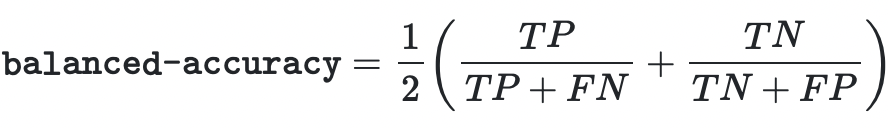

If the classifier performs equally well on either class, this term reduces to the conventional accuracy (i.e., the number of correct predictions divided by the total number of predictions).

In contrast, if the conventional accuracy is above chance only because the classifier takes advantage of an imbalanced test set, then the balanced accuracy, as appropriate, will drop to 1/n_classes.

balanced_accuracy_score  0.8081368469717984


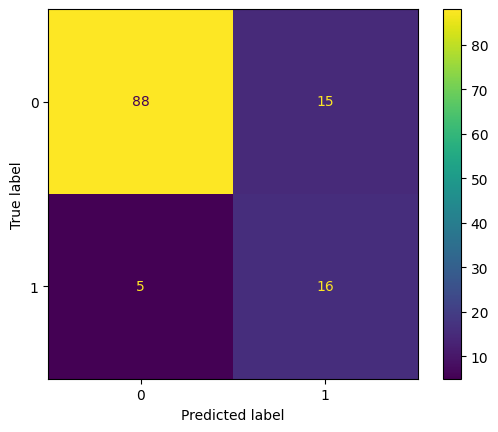

In [ ]:
clf = scores['estimator'][0]
clf.fit(df_undersampled_X,np.array(df_undersampled_Y['Class']))
y_pred_gb= clf.predict(test_X)
accuracy = balanced_accuracy_score(test_Y, y_pred_gb)
print("balanced_accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()


In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(test_Y, y_pred_gb, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.85      0.90       103
     class 1       0.52      0.76      0.62        21

    accuracy                           0.84       124
   macro avg       0.73      0.81      0.76       124
weighted avg       0.87      0.84      0.85       124



# Can we do better ?

Using PCA with 2 and 3 components for visualization

In [ ]:
pca = PCA(n_components=2,whiten=True)
pca.fit(df_undersampled_X)
X_2D=pca.transform(df_undersampled_X)

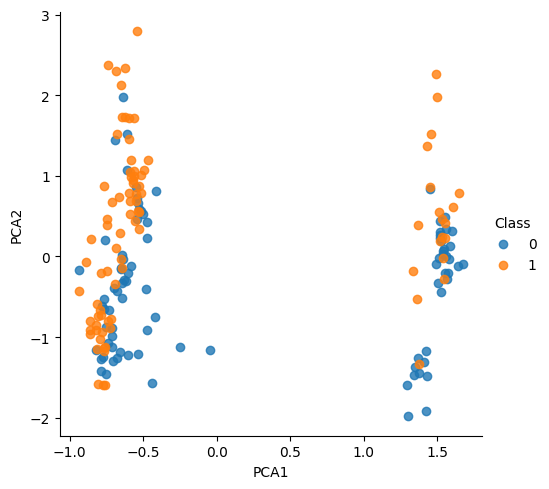

In [ ]:
df_undersampled['PCA1'] = X_2D[:, 0]
df_undersampled['PCA2'] = X_2D[:, 1]
sns.lmplot(x="PCA1", y="PCA2", hue='Class', data=df_undersampled, fit_reg=False);

We see that in the two-dimensional representation, the clusters are not well separated.

In [ ]:
pca_2=PCA(n_components=3)
pca_2.fit(df_undersampled_X)
X_3D=pca_2.transform(df_undersampled_X)

In [ ]:
a = X_3D[:, 0]
b = X_3D[:, 1]
d = X_3D[:, 2]

Text(0.5, 0, 'Third principal component')

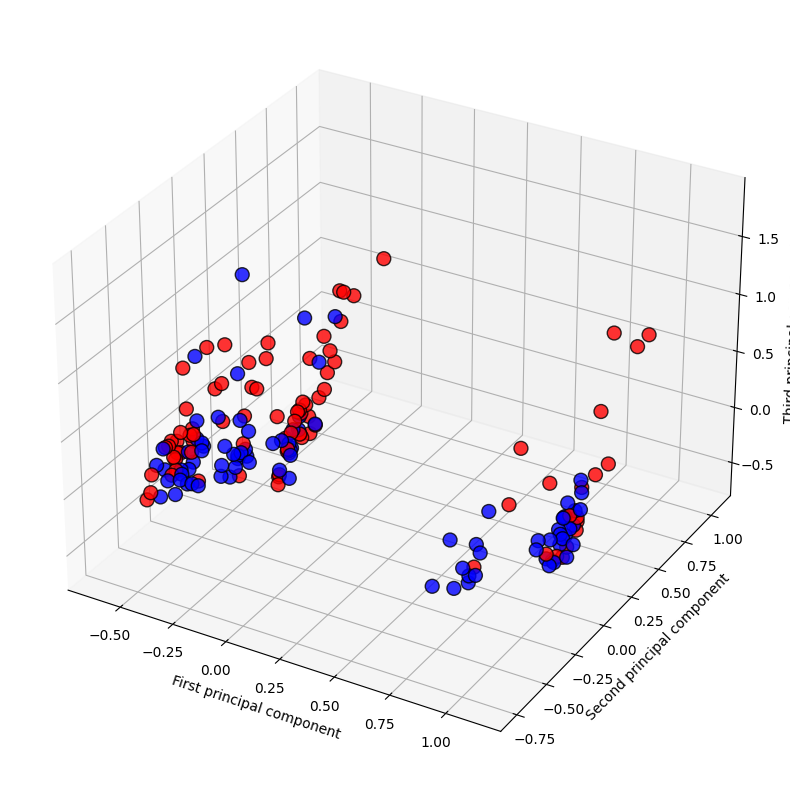

In [ ]:
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(["blue", "red"])
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(a,b,d, c=df_undersampled_Y, marker = 'o', alpha=0.8, s=100, cmap=mycmap, edgecolor='k')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# Lets find out the minimum no of PCA components needed to explain 100% of the variance in our balanced training dataset with original features


In [ ]:
pca_3=PCA(n_components=None)
pca_3.fit(df_undersampled_X)
X_pca=pca_3.transform(df_undersampled_X)

In [ ]:
pca_3.n_components_

52

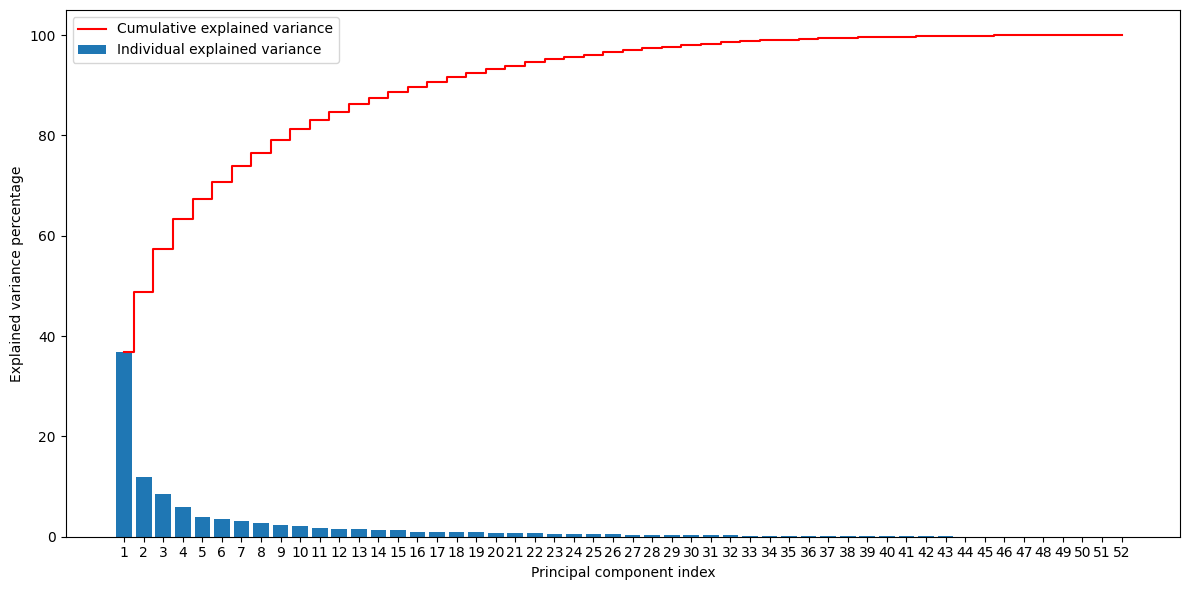

In [ ]:
exp_var = pca_3.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 53), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 53), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=np.arange(1, 53))
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("Barplot.png")

Using 35 or 36 PCA components, we can explain 100% of the variance in the data

In [ ]:
pca_4=PCA(n_components=0.99)
pca_4.fit(df_undersampled_X)
X_pca_4=pca_4.transform(df_undersampled_X)


In [ ]:
pca_4.n_components_

35

In [ ]:
# Building a dataframe from the Principal Components array

pca_db_cols = [] # Initialize an empty array to hold the column names
for i in range(0, len(X_pca_4[0])): # Iterate through the number of columns in the array
  pca_db_cols.append("PC"+str(i)) # Build and append column names
pca_db_df = pd.DataFrame(data=X_pca_4, columns=pca_db_cols)
pca_db_df.shape

(174, 35)

In [ ]:
from sklearn.model_selection import cross_validate


clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, pca_db_df,np.array(df_undersampled_Y['Class']), cv=5, return_estimator=True)
print(scores)


{'fit_time': array([2.3291595 , 2.0643208 , 2.08328915, 2.0924902 , 2.08603239]), 'score_time': array([0.00356388, 0.0037961 , 0.00332093, 0.00320911, 0.00314736]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.77142857, 0.68571429, 0.77142857, 0.71428571, 0.73529412])}


In [ ]:
test_X_pca = pca_4.transform(test_X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


balanced_accuracy_score  0.8552935737401757


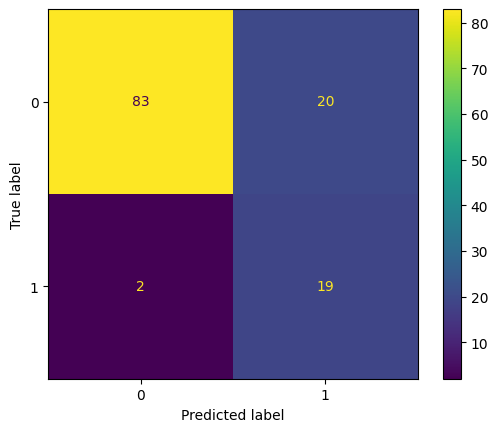

In [ ]:
clf = scores['estimator'][0]
clf.fit(pca_db_df,np.array(df_undersampled_Y['Class']))
y_pred_gb= clf.predict(test_X_pca)
accuracy = balanced_accuracy_score(test_Y, y_pred_gb)
print("balanced_accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

Thus we see using 35 PCA components instead of 53 original features, our models performance is better.
balanced_accuracy_score  0.8552935737401757

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(test_Y, y_pred_gb, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      0.81      0.88       103
     class 1       0.49      0.90      0.63        21

    accuracy                           0.82       124
   macro avg       0.73      0.86      0.76       124
weighted avg       0.89      0.82      0.84       124



#Combining 35 PCA components & 30 best original features.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion

selection = SelectKBest(k=30)

pca = PCA(n_components=0.99)

# Build estimator from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(df_undersampled_X, np.array(df_undersampled_Y['Class'])).transform(df_undersampled_X)
print("Combined space has", X_features.shape[1], "features")


Combined space has 65 features


In [ ]:
X_features.shape

(174, 65)

In [ ]:
# Using the combining estimator to transform test dataset:
test_X_features = combined_features.transform(test_X)
test_X_features.shape

(124, 65)

In [ ]:
b = df_undersampled_Y["Class"].values.tolist()

In [ ]:
combined_dataframe = pd.DataFrame(X_features)

# Attaching 'Class'
combined_dataframe['Class'] = b

combined_dataframe["Class"].value_counts()

1    87
0    87
Name: Class, dtype: int64

In [ ]:
combined_dataframe.shape

(174, 66)

In [ ]:
c = test_Y["Class"].values.tolist()

In [ ]:
combined_test_dataframe = pd.DataFrame(test_X_features)

# Attaching 'Class'
combined_test_dataframe['Class'] = c

combined_test_dataframe["Class"].value_counts()

0    103
1     21
Name: Class, dtype: int64

In [ ]:
combined_test_dataframe.shape

(124, 66)

In [ ]:
combined_test_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Class
0,0.896855,0.011537,0.487205,0.018597,-0.018665,0.023335,-0.610071,-0.313225,-0.362738,0.003721,...,0.121263,0.106356,0.000000,0.000000,0.000000,0.001375,0.185929,1.000000,0.0,1
1,-0.421292,-0.207228,-0.252693,-0.215223,0.230391,-0.001075,0.030070,-0.008921,0.156608,-0.021622,...,0.042790,0.225525,0.036570,0.000923,0.004328,0.001616,0.124182,0.004541,1.0,0
2,0.946481,-0.412917,0.058431,-0.211939,0.220033,0.141946,0.054493,0.192499,0.139909,0.142356,...,0.044361,0.327695,0.000000,0.000721,0.000000,0.052605,0.086582,1.000000,0.0,0
3,-0.447204,-0.220466,-0.052678,-0.197891,0.026462,-0.193765,-0.045842,0.053881,-0.190529,0.042650,...,0.077775,0.271485,0.020660,0.000000,0.011686,0.042200,0.501811,0.037553,1.0,0
4,-0.191008,-0.385267,0.242467,0.395241,0.139595,-0.225693,-0.392160,0.323804,-0.218079,-0.019308,...,0.045713,0.132325,0.001236,0.002444,0.012984,0.007915,0.453601,0.513489,1.0,0


# Saving the combined features of training and transformed test features to the combined space

In [ ]:
combined_dataframe.to_csv("dataset_65_features_train.csv")
combined_test_dataframe.to_csv("dataset_65_features_test.csv")

# Performing Cross Validation on the new dataset

In [118]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(65, 1)))
# model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_features,np.array(df_undersampled_Y['Class']), epochs=30, batch_size=32, verbose=1)


Epoch 1/30
6/6 [==============================] - 3s 13ms/step - loss: 0.6898 - accuracy: 0.5287
Epoch 2/30
6/6 [==============================] - 0s 15ms/step - loss: 0.6642 - accuracy: 0.7644
Epoch 3/30
6/6 [==============================] - 0s 16ms/step - loss: 0.6183 - accuracy: 0.7759
Epoch 4/30
6/6 [==============================] - 0s 17ms/step - loss: 0.5637 - accuracy: 0.7414
Epoch 5/30
6/6 [==============================] - 0s 14ms/step - loss: 0.4898 - accuracy: 0.8448
Epoch 6/30
6/6 [==============================] - 0s 12ms/step - loss: 0.4187 - accuracy: 0.8736
Epoch 7/30
6/6 [==============================] - 0s 14ms/step - loss: 0.3659 - accuracy: 0.8563
Epoch 8/30
6/6 [==============================] - 0s 14ms/step - loss: 0.3690 - accuracy: 0.8276
Epoch 9/30
6/6 [==============================] - 0s 13ms/step - loss: 0.3544 - accuracy: 0.8736
Epoch 10/30
6/6 [==============================] - 0s 12ms/step - loss: 0.2894 - accuracy: 0.9138
Epoch 11/30
6/6 [============

In [119]:
# Evaluating the model

_, accuracy = model.evaluate(test_X_features, test_Y, verbose=0)
print("Accuracy:", accuracy)

Accuracy: 0.8870967626571655


4/4 [==============================] - 0s 6ms/step


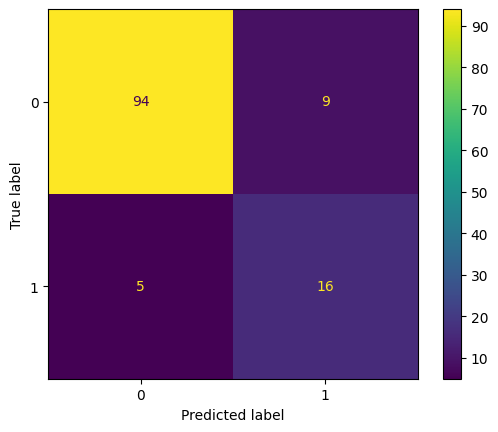

In [123]:
y_pred_gb= model.predict(test_X_features)
threshold = 0.5  # Adjust the threshold value as per your requirement

# Applying the threshold to obtain predicted labels
y_pred = (y_pred_gb >= threshold).astype(int)

cm = confusion_matrix(test_Y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()


In [ ]:
from sklearn.model_selection import cross_validate


clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, X_features,np.array(df_undersampled_Y['Class']), cv=5, return_estimator=True)
print(scores)


{'fit_time': array([3.04092932, 3.01491761, 4.44256449, 3.05832028, 3.11307693]), 'score_time': array([0.00208926, 0.00273228, 0.00196099, 0.00202394, 0.00195241]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.94285714, 0.85714286, 0.97142857, 0.94285714, 0.85294118])}


balanced_accuracy_score  0.855755894590846


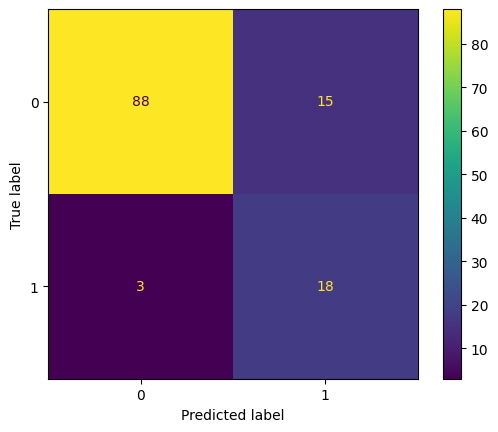

In [ ]:

clf = scores['estimator'][2]
clf.fit(X_features,np.array(df_undersampled_Y['Class']))
y_pred_gb= clf.predict(test_X_features)
accuracy = balanced_accuracy_score(test_Y, y_pred_gb)
print("balanced_accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()



Thus with in the combined space, our model performance gets slightly better .

# Since all our features are continuous, lets bin the  original dataset into intervals and then perform onehot encoding.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=2, encode="onehot")
enc.fit(df_undersampled_X)
X_binned = enc.transform(df_undersampled_X)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:27

Except 8 features , rest of them gets binned. There were 53 original features . After this step, we upgrade to 96 features.

In [ ]:
X_binned.shape

(174, 96)

Cross Validation on the new dataset

In [ ]:
# Binning the test dataset
test_X_features_binned=enc.transform(test_X)

In [ ]:
test_X_features_binned.shape

(124, 96)

In [ ]:
from sklearn.model_selection import cross_validate


clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, X_binned,np.array(df_undersampled_Y['Class']), cv=5, return_estimator=True)
print(scores)


{'fit_time': array([1.56098413, 1.53570533, 1.46694708, 1.45792747, 1.76784015]), 'score_time': array([0.00312424, 0.00277114, 0.00285482, 0.00301242, 0.00383973]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.94285714, 0.71428571, 0.94285714, 0.8       , 0.73529412])}


balanced_accuracy_score  0.7639852057327785


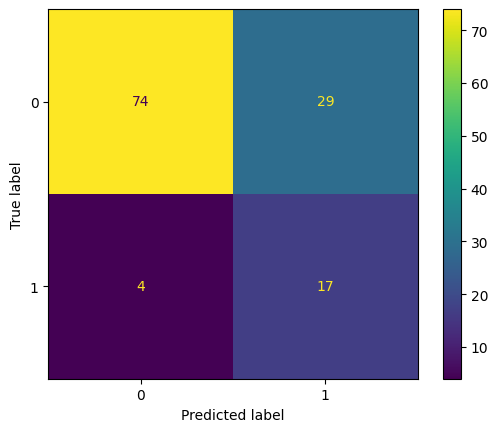

In [ ]:

clf = scores['estimator'][0]
clf.fit(X_binned,np.array(df_undersampled_Y['Class']))
y_pred_gb= clf.predict(test_X_features_binned)
accuracy = balanced_accuracy_score(test_Y, y_pred_gb)
print("balanced_accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

# Just binning the original features, degraded our performance. Not saving this dataset for future modelling.

Lets create a new dataset with TruncatedSVD applied on original datset with 51 features and 40 best original features

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
X = csr_matrix(df_undersampled_X)
selection = SelectKBest(k=40)

svd = TruncatedSVD(n_components=50, n_iter=8, random_state=42)

# Build estimator from svd and Univariate selection:
combined_features = FeatureUnion([("svd", svd), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, np.array(df_undersampled_Y['Class'])).transform(X)
print("Combined space has", X_features.shape[1], "features")


Combined space has 90 features


In [ ]:
X_features.shape

(174, 90)

In [ ]:
# Transforming the Test dataset to the combined space

test_X_features_enc = csr_matrix(test_X)
test_X_features_enc=combined_features.transform(test_X_features_enc)

# In this training datset, in the first fold we have converged.

In [ ]:
from sklearn.model_selection import cross_validate


clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=2,
                 random_state=40,loss='log_loss')

scores = cross_validate(clf, X_features,np.array(df_undersampled_Y['Class']), cv=5, return_estimator=True)
print(scores)

{'fit_time': array([8.91760468, 9.57270217, 4.95137525, 3.30569959, 4.60805941]), 'score_time': array([0.00409102, 0.00516582, 0.00249624, 0.00233936, 0.00314784]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1000,
                           random_state=40), GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1000,
                           random_state=40), GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1000,
                           random_state=40), GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1000,
                           random_state=40), GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1000,
                           random_state=40)], 'test_score': array([0.97142857, 0.85714286, 0.88571429, 0.91428571, 0.82352941])}


balanced_accuracy_score  0.8226999537679149


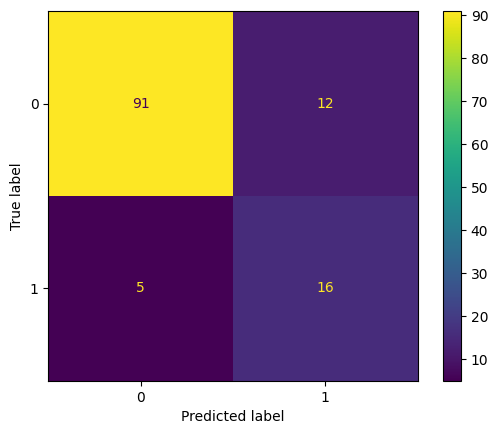

In [ ]:

clf = scores['estimator'][0]
clf.fit(X_features,np.array(df_undersampled_Y['Class']))
y_pred_gb= clf.predict(test_X_features_enc)
accuracy = balanced_accuracy_score(test_Y, y_pred_gb)
print("balanced_accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
# Convert sparse matrix to DataFrame
sparse_matrix_dataframe = pd.DataFrame.sparse.from_spmatrix(X_features)
sparse_matrix_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.657203,-0.464805,0.082439,0.409339,-0.323556,-0.131238,0.039490,-0.078830,-0.195746,-0.021336,...,0.052424,0.091406,0.039257,0.000823,0.000000,0.084943,0.000000,0.539074,0.008395,1.0
1,1.277997,-0.587535,0.149429,0.190942,0.264684,-0.115427,-0.167656,-0.023809,-0.024541,0.091706,...,0.353835,0.226209,0.132535,0.000000,0.011902,0.000000,0.011796,0.145787,0.003136,1.0
2,2.095117,-0.315485,-0.341506,0.193720,-0.306882,-0.087630,0.173951,0.025590,-0.074315,0.004819,...,0.085897,0.298138,0.078775,0.000801,0.000000,0.012226,0.054409,0.525018,0.000738,1.0
3,1.847128,-0.315587,-0.247333,-0.202044,-0.272715,0.045553,-0.035554,0.034359,0.021881,-0.081180,...,0.022098,0.211003,0.047632,0.000624,0.018178,0.000000,0.050755,0.378264,0.003991,1.0
4,1.815103,-0.324473,-0.336229,-0.076674,-0.404680,-0.111217,0.115728,0.209041,-0.089493,-0.154547,...,0.064602,0.104391,0.041762,0.000000,0.005410,0.000000,0.074267,0.601935,0.000402,1.0


In [ ]:
# Attaching 'Class'
sparse_matrix_dataframe['Class'] = b

In [ ]:
sparse_matrix_dataframe.shape

(174, 91)

In [ ]:
# Convert test sparse matrix to DataFrame
test_sparse_matrix_dataframe = pd.DataFrame.sparse.from_spmatrix(test_X_features_enc)
test_sparse_matrix_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.555890,0.923312,0.287460,0.373822,-0.079525,0.025405,-0.017162,-0.644930,-0.429368,0.044274,...,0.121263,0.106356,0.000000,0.000000,0.000000,0.000000,0.001375,0.185929,1.000000,0.0
1,1.585018,-0.404315,0.089739,-0.427301,-0.017983,0.162698,0.063591,0.018092,0.136265,0.085335,...,0.042790,0.225525,0.036570,0.000923,0.004328,0.000000,0.001616,0.124182,0.004541,1.0
2,1.395326,0.949482,0.435361,-0.278531,-0.029251,0.186087,-0.088697,0.068758,0.221867,-0.179716,...,0.044361,0.327695,0.000000,0.000721,0.000000,0.000000,0.052605,0.086582,1.000000,0.0
3,1.593293,-0.428922,0.201002,-0.251550,-0.075430,-0.105701,0.154283,-0.034628,-0.161828,-0.096938,...,0.077775,0.271485,0.020660,0.000000,0.011686,0.176115,0.042200,0.501811,0.037553,1.0
4,1.685027,-0.166180,0.501674,0.008468,0.563250,-0.252846,0.080228,-0.318744,-0.111126,-0.212057,...,0.045713,0.132325,0.001236,0.002444,0.012984,0.000000,0.007915,0.453601,0.513489,1.0


In [ ]:
# Attaching 'Class'
test_sparse_matrix_dataframe['Class'] = c

# Saving the dataframe for furthur modelling.

In [ ]:
sparse_matrix_dataframe.to_csv("sparse_matrix_train.csv")
test_sparse_matrix_dataframe.to_csv("sparse_matrix_test.csv")

<ipython-input-184-7fc8fbbecb4a>:1: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  sparse_matrix_dataframe.to_csv("sparse_matrix_train.csv")
<ipython-input-184-7fc8fbbecb4a>:2: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  test_sparse_matrix_dataframe.to_csv("sparse_matrix_test.csv")


In [ ]:
pip install autofeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 10.9 MB/s eta 0:00:00


AutoFeat

Autofeat is another good feature engineering open-source library. It automates feature synthesis, feature selection, and fitting a linear machine learning model.

The algorithm behind Autofeat is quite simple. It generates non-linear features, for example log(x), x2, or x3. And different operands are used like negative, positive and decimals, while creating the feature space. This results in exponential growth in the feature space. The categorical features are converted into one-hot encoded features.

Now that we have so many features, it’s necessary to select important features. First Autofeat removes the highly correlated features, so now it relies on L1 regularization and removes the feature with low coefficient(features with low weights after training linear/logistic regression with L1 regularization). This process of selecting correlated features and removing the features with L1 regularization is repeated several times until only a few features are left. These features are selected through this iterative process which actually describes the dataset.



In [ ]:
from autofeat import AutoFeatRegressor
# Create an instance of AutoFeatRegressor
afreg = AutoFeatRegressor()

X_features=X_features.toarray()
test_X_features_enc = test_X_features_enc.toarray()

# Fit AutoFeatRegressor to the data
afreg.fit(X_features, np.array(df_undersampled_Y['Class']))

X_new = afreg.transform(X_features)
test_X_new = afreg.transform(test_X_features_enc)


In [ ]:
X_new.shape

(174, 124)

In [ ]:
test_X_new.shape

(124, 124)

In [ ]:
clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, X_new,np.array(df_undersampled_Y['Class']), cv=5, return_estimator=True)
print(scores)


{'fit_time': array([5.18911719, 5.86601329, 5.51998568, 4.97086191, 6.39008689]), 'score_time': array([0.00463557, 0.01006269, 0.00452518, 0.00498486, 0.00436544]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.94285714, 0.85714286, 0.94285714, 0.94285714, 0.88235294])}


In [ ]:
test_X_new = test_X_new.fillna(0)
test_X_new = test_X_new.replace([np.inf, -np.inf], 0)
test_X_new = test_X_new[[col for col in test_X_new.columns if col not in collinear_features]]

accuracy_score  0.8387096774193549


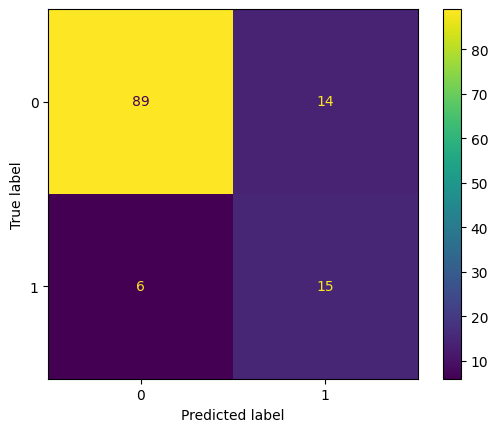

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

clf = scores['estimator'][0]
clf.fit(X_new,np.array(df_undersampled_Y['Class']))
y_pred_gb= clf.predict(test_X_new)
accuracy = accuracy_score(test_Y, y_pred_gb)
print("accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()


In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184097 sha256=9bf52430f88f40004579d2c3e84fbd4d3e63a2e8b1b1855ba94b9ac081446d91
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod


In [ ]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

In [ ]:
# Create a new DataFrame with the added column
Train_data_raw_features = df_undersampled_X.copy()

# Attaching 'Class'
Train_data_raw_features['Class'] = df_undersampled[["Class"]].astype(int)


# Save the new DataFrame to a CSV file
Train_data_raw_features.to_csv('Balanced_Train_data_raw_features.csv', index=False)

# Print the new DataFrame
Train_data_raw_features.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,feature_B,Class
436,0.084329,0.159848,0.015801,0.058559,0.000000,0.227069,0.000000,0.243578,0.003871,0.072793,...,0.000823,0.000000,0.279457,0.084943,0.000000,0.259513,0.539074,0.008395,1.0,1
36,0.031623,0.127299,0.000000,0.007896,0.000000,0.081113,0.000000,0.000000,0.000000,0.042619,...,0.000000,0.011902,0.251872,0.000000,0.011796,0.219596,0.145787,0.003136,1.0,1
118,0.094167,0.406854,0.000000,0.263596,0.081651,0.149493,0.000000,0.218955,0.000000,0.081776,...,0.000801,0.000000,0.139058,0.012226,0.054409,0.430171,0.525018,0.000738,1.0,1
93,0.023893,0.029063,0.000000,0.007163,0.000000,0.091016,0.007901,0.224446,0.003708,0.070648,...,0.000624,0.018178,0.093529,0.000000,0.050755,0.374806,0.378264,0.003991,1.0,1
162,0.056922,0.133928,0.000000,0.184633,0.087868,0.097854,0.000237,0.198051,0.000000,0.072854,...,0.000000,0.005410,0.039842,0.000000,0.074267,0.154432,0.601935,0.000402,1.0,1


In [ ]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=40)
cblof_clf.fit(Train_data_raw_features[['FS', 'Class']])
Train_data_raw_features['CBLOF_Clf'] = cblof_clf.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
Train_data_raw_features['CBLOF_Clf'].value_counts()

0    165
1      9
Name: CBLOF_Clf, dtype: int64

In [ ]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=40)
cblof_clf.fit(Train_data_raw_features[['AM', 'Class']])
Train_data_raw_features['CBLOF_Clf'] = cblof_clf.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
Train_data_raw_features['CBLOF_Clf'].value_counts()

0    165
1      9
Name: CBLOF_Clf, dtype: int64

In [ ]:
Train_data_raw_features.shape

(174, 54)

In [ ]:
# Drop rows where CBLOF_Clf is 1
df_filtered = Train_data_raw_features.drop(Train_data_raw_features[Train_data_raw_features['CBLOF_Clf'] == 1].index)

# Print the DataFrame after dropping rows
df_filtered.shape

(165, 54)

In [ ]:
# Separate the features (columns) and the target column
X = df_filtered.drop(['Class','CBLOF_Clf'], axis=1)
y = df_filtered['Class']

In [ ]:

clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, X,y, cv=5, return_estimator=True)
print(scores)


{'fit_time': array([3.28990626, 3.00348043, 4.7197299 , 2.3275311 , 2.2342639 ]), 'score_time': array([0.00434256, 0.00567508, 0.00419545, 0.0038898 , 0.00355506]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([1.        , 0.87878788, 0.90909091, 0.90909091, 0.81818182])}


accuracy_score  0.8225806451612904


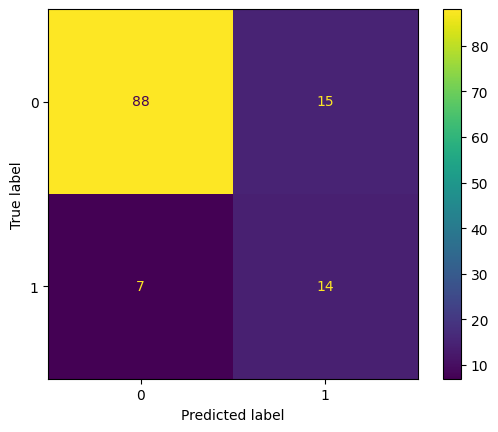

In [ ]:

clf = scores['estimator'][0]
clf.fit(X,y)
y_pred_gb= clf.predict(test_X)
accuracy = accuracy_score(test_Y, y_pred_gb)
print("accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
# Create a new DataFrame with the added column
Train_data_raw_features = X_new.copy()

# Attaching 'Class'
Train_data_raw_features['Class'] = df_undersampled[["Class"]].astype(int)


# Print the new DataFrame
Train_data_raw_features.head()

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,1/(x020*x046),x001**3*x045**3,sqrt(x083)/x040,x070*sqrt(x075),sqrt(x078)/x035,x029*sqrt(x082),sqrt(x085)*x087**2,sqrt(x082)*Abs(x008),sqrt(x085)*log(x052),Class
0,1.657203,-0.464805,0.082439,0.409339,-0.323556,-0.131238,0.039490,-0.078830,-0.195746,-0.021336,...,5350.640850,-1.664303e-07,1.967134,0.043279,-17.901699,-0.005953,0.084695,0.038784,-0.827050,1.0
1,1.277997,-0.587535,0.149429,0.190942,0.264684,-0.115427,-0.167656,-0.023809,-0.024541,0.091706,...,-444.674950,2.554447e-08,-0.000000,0.114874,-0.000000,-0.000462,0.000000,0.008934,-0.000000,NaN
2,2.095117,-0.315485,-0.341506,0.193720,-0.306882,-0.087630,0.173951,0.025590,-0.074315,0.004819,...,481.340651,1.269681e-08,0.414491,0.130998,0.000000,-0.008878,0.030478,0.020858,-0.147427,NaN
3,1.847128,-0.315587,-0.247333,-0.202044,-0.272715,0.045553,-0.035554,0.034359,0.021881,-0.081180,...,-3234.464962,-2.131599e-07,-0.487451,0.080094,8.278115,0.016997,0.000000,0.004775,-0.000000,NaN
4,1.815103,-0.324473,-0.336229,-0.076674,-0.404680,-0.111217,0.115728,0.209041,-0.089493,-0.154547,...,2731.244247,6.568252e-07,0.000000,0.040638,-0.000000,-0.011154,0.000000,0.018289,-0.000000,1.0


In [ ]:
Train_data_raw_features = Train_data_raw_features.fillna(0)
Train_data_raw_features = Train_data_raw_features.replace([np.inf, -np.inf], 0)
# Train_data_raw_features = test_X_new[[col for col in test_X_new.columns if col not in collinear_features]]

In [ ]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=40)
cblof_clf.fit(Train_data_raw_features[['x000', 'Class']])
Train_data_raw_features['CBLOF_Clf'] = cblof_clf.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
Train_data_raw_features['CBLOF_Clf'].value_counts()

0    165
1      9
Name: CBLOF_Clf, dtype: int64

In [ ]:
Train_data_raw_features.shape

(174, 126)

In [ ]:
# Drop rows where CBLOF_Clf is 1
df_filtered = Train_data_raw_features.drop(Train_data_raw_features[Train_data_raw_features['CBLOF_Clf'] == 1].index)

# Print the DataFrame after dropping rows
df_filtered.shape

(165, 126)

In [ ]:
# Separate the features (columns) and the target column
X = df_filtered.drop(['Class','CBLOF_Clf'], axis=1)
y = df_filtered['Class']

In [ ]:
clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, X,y, cv=5, return_estimator=True)
print(scores)


{'fit_time': array([5.23852801, 4.88038206, 6.55654001, 4.85792065, 4.74921441]), 'score_time': array([0.0045557 , 0.00453091, 0.00441527, 0.0042665 , 0.00430226]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.84848485, 0.87878788, 0.90909091, 0.87878788, 0.90909091])}


accuracy_score  0.8064516129032258


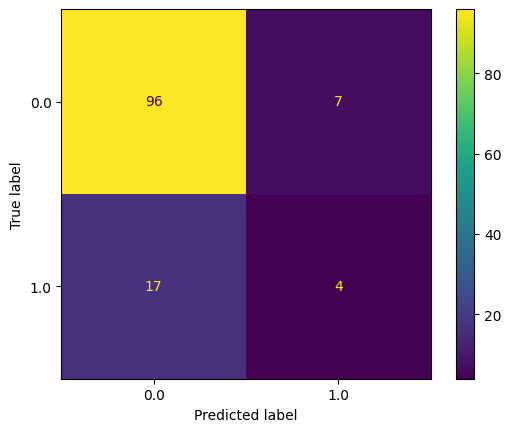

In [ ]:
clf = scores['estimator'][4]
clf.fit(X,y)
y_pred_gb= clf.predict(test_X_new)
accuracy = accuracy_score(test_Y, y_pred_gb)
print("accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
combined_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Class
0,-0.496747,0.149810,0.397568,-0.108458,-0.288593,-0.063982,-0.052353,-0.183641,-0.168600,0.033497,...,0.052424,0.091406,0.039257,0.000823,0.000000,0.000000,0.539074,0.008395,1.0,1
1,-0.573408,-0.303410,0.068527,0.399478,-0.224812,0.121986,-0.019225,-0.172619,0.039964,0.097872,...,0.353835,0.226209,0.132535,0.000000,0.011902,0.011796,0.145787,0.003136,1.0,1
2,-0.396077,0.648708,0.113276,-0.229580,-0.081809,-0.187861,0.034238,-0.021366,-0.069018,-0.007130,...,0.085897,0.298138,0.078775,0.000801,0.000000,0.054409,0.525018,0.000738,1.0,1
3,-0.366006,0.295719,-0.190153,-0.326697,0.000818,0.052466,0.034265,0.028333,-0.000302,0.116025,...,0.022098,0.211003,0.047632,0.000624,0.018178,0.050755,0.378264,0.003991,1.0,1
4,-0.374010,0.401989,-0.144074,-0.359085,-0.169946,-0.135150,0.211682,0.040174,-0.132287,0.102739,...,0.064602,0.104391,0.041762,0.000000,0.005410,0.074267,0.601935,0.000402,1.0,1


In [ ]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=40)
cblof_clf.fit(combined_dataframe[[0, 'Class']])
combined_dataframe['CBLOF_Clf'] = cblof_clf.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
combined_dataframe['CBLOF_Clf'].value_counts()

0    165
1      9
Name: CBLOF_Clf, dtype: int64

In [ ]:
# Drop rows where CBLOF_Clf is 1
df_filtered = combined_dataframe.drop(combined_dataframe[combined_dataframe['CBLOF_Clf'] == 1].index)

# Print the DataFrame after dropping rows
df_filtered.shape

(165, 67)

In [ ]:
# Separate the features (columns) and the target column
X = df_filtered.drop(['Class','CBLOF_Clf'], axis=1)
y = df_filtered['Class']

In [ ]:
clf = GradientBoostingClassifier(n_estimators=1000,
                 learning_rate=0.01,
                 max_depth=3,
                 random_state=42,loss='log_loss')

scores = cross_validate(clf, X,y, cv=5, return_estimator=True)
print(scores)


{'fit_time': array([3.20829582, 2.87607217, 2.97978735, 7.47975922, 5.70302844]), 'score_time': array([0.00465965, 0.00402212, 0.00541329, 0.03117776, 0.00401354]), 'estimator': [GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42), GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=42)], 'test_score': array([0.96969697, 0.87878788, 0.93939394, 0.93939394, 0.90909091])}


accuracy_score  0.8460471567267683


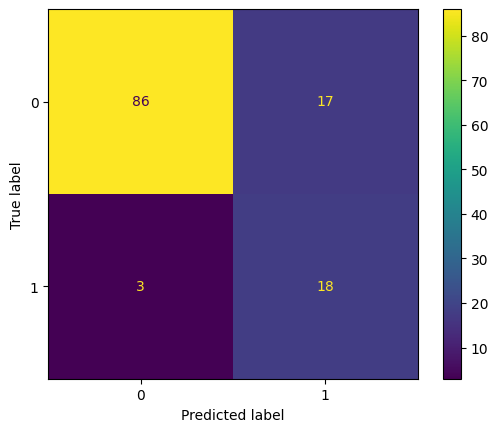

In [ ]:
clf = scores['estimator'][0]
clf.fit(X,y)
y_pred_gb= clf.predict(test_X_features)
accuracy = balanced_accuracy_score(test_Y, y_pred_gb)
print("accuracy_score ",accuracy)
cm = confusion_matrix(test_Y, y_pred_gb, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()